In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


/home/yosh/gradio-demo/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

In [2]:
dataset = load_dataset("Xenova/quickdraw-small")

# could be used for data-augmentation
preprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0,), (1,))  
])

def preprocess_ops(examples):
    examples['image'] = [preprocess(image) for image in examples['image']]
    return examples

dataset.set_transform(preprocess_ops)

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4500000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 250000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 250000
    })
})

In [4]:
train_dataset, test_dataset, val_dataset = dataset['train'], dataset['test'], dataset['valid']
train_dataset = train_dataset.shard(num_shards=10, index=0)
names = train_dataset.features['label'].names
n_classes = len(names)

print(f'trainset size {len(train_dataset)}')

trainset size 450000


In [21]:
print(dir(test_dataset))

['_TF_DATASET_REFS', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getitems__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_build_local_temp_path', '_check_index_is_initialized', '_data', '_estimate_nbytes', '_fast_select_column', '_fingerprint', '_format_columns', '_format_kwargs', '_format_type', '_generate_tables_from_cache_file', '_generate_tables_from_shards', '_get_cache_file_path', '_get_output_signature', '_getitem', '_indexes', '_indices', '_info', '_map_single', '_new_dataset_with_indices', '_output_all_columns', '_push_parquet_shards_to_hub', '_push_parquet_shards_to_hub_si

In [ ]:
print(test_dataset.description)

TypeError: 'str' object is not callable

In [5]:
import json

with open('labels.json', 'w') as f:
    json.dump(names, f)

In [6]:
def id_to_class(idx):
    return names[idx]

label windmill


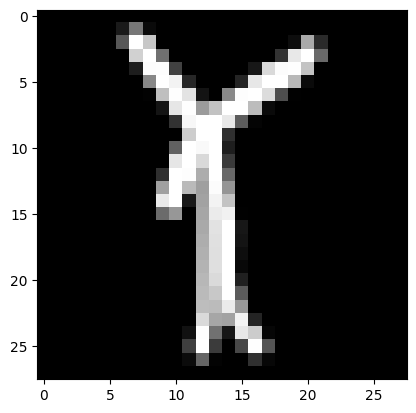

In [7]:

idx = torch.randint(0, 100, (1,))
img, label = test_dataset[idx]['image'], test_dataset[idx]['label']
img = img[0].squeeze(dim=0)
print(f'label {id_to_class(label[0])}')
plt.imshow(img, cmap='gray')

In [18]:
for batch in test_dataset:
    print(f'data {batch['label']} label ')
    break

data 197 label 


In [19]:
all_labels = [item['label'] for item in test_dataset]
print(len(all_labels))

250000


In [24]:
print(all_labels)

[197, 231, 19, 149, 244, 157, 52, 174, 107, 111, 74, 307, 216, 331, 330, 93, 192, 121, 263, 47, 153, 173, 27, 120, 186, 13, 123, 294, 272, 74, 322, 227, 306, 290, 255, 258, 298, 107, 189, 298, 174, 35, 61, 116, 331, 125, 272, 213, 46, 120, 342, 97, 50, 172, 222, 200, 250, 256, 32, 147, 142, 39, 220, 138, 166, 48, 335, 112, 231, 45, 276, 194, 107, 81, 283, 253, 118, 153, 79, 95, 204, 249, 272, 332, 200, 232, 319, 138, 112, 63, 338, 314, 27, 62, 15, 192, 36, 123, 341, 274, 237, 262, 117, 173, 95, 270, 261, 170, 206, 228, 63, 243, 6, 10, 2, 48, 262, 222, 19, 191, 4, 140, 115, 203, 206, 48, 340, 221, 29, 314, 194, 331, 37, 43, 91, 197, 191, 108, 165, 270, 289, 166, 100, 183, 238, 107, 281, 310, 38, 262, 62, 115, 323, 228, 110, 232, 72, 272, 33, 16, 40, 271, 216, 150, 28, 53, 164, 54, 341, 337, 64, 209, 56, 16, 327, 145, 212, 56, 135, 170, 256, 266, 334, 142, 335, 288, 80, 90, 315, 323, 316, 295, 4, 40, 84, 206, 262, 139, 231, 7, 342, 307, 192, 277, 272, 212, 333, 195, 55, 115, 185, 241, 45

## DataLoader

In [8]:
from cnn import CNN # type: ignore

params = {
    'n_filters': 30,
    'hidden_dim': 100,
    'n_layers': 2,
    'n_classes': n_classes
}
model = CNN(**params).to(device)
n_params = sum([p.numel() for p in model.parameters()])
print(f'Number of params {n_params}')

Number of params 197385


In [9]:
# hyperparameters
lr = 0.001
batch_size = 128*4
n_epochs = 1

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

trainLoader, testLoader = DataLoader(train_dataset, batch_size=batch_size), DataLoader(test_dataset, batch_size=batch_size)

In [10]:
def train(model, trainLoader, testLoader, criterion, optimizer, n_epochs):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0
        train_acc = 0
        for batch in tqdm(trainLoader):
            data, labels = batch['image'], batch['label']
            out = model(data)
            preds = out.argmax(dim=1)
            loss = criterion(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (preds == labels).sum().item()

        train_loss /= len(trainLoader)
        train_acc /= len(trainLoader.dataset)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for batch in tqdm(testLoader, disable=True):
                data, labels = batch['image'], batch['label']
                out = model(data)
                loss = criterion(out, labels)
                preds = out.argmax(dim=1)
                test_loss += loss.item()
                test_acc += (preds == labels).sum().item()

        test_loss /= len(testLoader)
        test_acc /= len(testLoader.dataset)
        test_accs.append(test_acc)
        test_losses.append(test_loss)

        print(f'epoch {epoch} | train loss {train_loss:.3f} train acc {train_acc:.2f} | test loss {test_loss:.3f} test acc {test_acc:.2f}')
    return train_losses, train_accs, test_losses, test_accs


In [11]:
train_losses, train_accs, test_losses, test_accs = train(model, trainLoader, testLoader, criterion, optimizer, n_epochs)

100%|██████████| 879/879 [03:44<00:00,  3.92it/s]


epoch 1 | train loss 3.933 train acc 0.19 | test loss 2.800 test acc 0.38


In [12]:
if max(test_accs) > 0.8:
    torch.save(model.state_dict(), 'weights/cnn.pth')

Validation
---

In [13]:
from sklearn.metrics import precision_recall_fscore_support
from gradio_demo.model.utils import get_validation_metrics

# def get_validation_metrics(model, val_dataset, batch_size, criterion, device):
#     valLoader = DataLoader(val_dataset, batch_size=batch_size)
#     all_preds, all_labels = [], []
#     val_loss, val_acc = 0, 0
#     model.eval()
#     with torch.no_grad():
#         for batch in tqdm(valLoader):
#             data, labels = batch['image'].to(device), batch['label'].to(device)
#             out = model(data)
#             loss = criterion(out, labels)
#             preds = out.argmax(dim=1)
#             val_loss += loss.item()
#             val_acc += (preds == labels).sum().item()
#             all_preds.extend(preds.detach().cpu().numpy())
#             all_labels.extend(labels.detach().cpu().numpy())

#         val_loss /= len(valLoader)
#         val_acc /= len(valLoader.dataset)

#     precision, recall, f1, _ = precision_recall_fscore_support(
#         all_labels, all_preds, average='weighted'  # or 'weighted' depending on your preference
#     )
#     metrics = {
#         'loss': val_loss,
#         'accuracy': val_acc,
#         'precision': precision,
#         'recall': recall,
#         'f1_score': f1
#     }
#     return metrics

val_metrics = get_validation_metrics(model, val_dataset, batch_size=256, criterion=criterion, device=device)

Validating: 100%|██████████| 977/977 [00:46<00:00, 21.17it/s]


In [14]:
for k, v in val_metrics.items():
    print(f'{k}: {v:0.3f}')

loss: 2.800
accuracy: 0.375
precision: 0.380
recall: 0.375
f1_score: 0.347
